Running XGBoost Learning Rate Analysis...


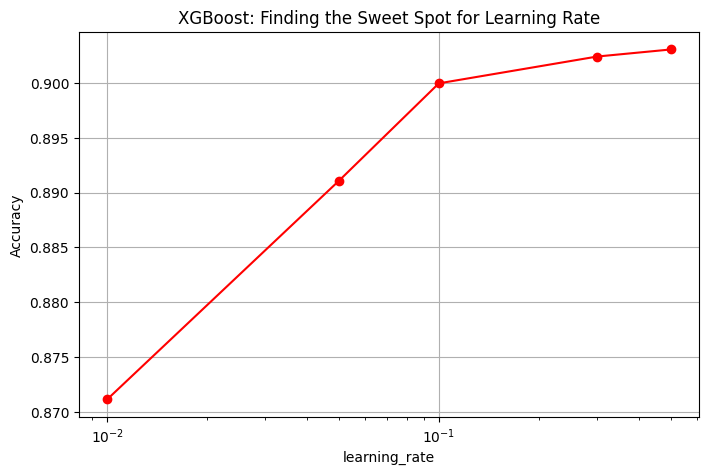

Running Grid Search for Heatmap...


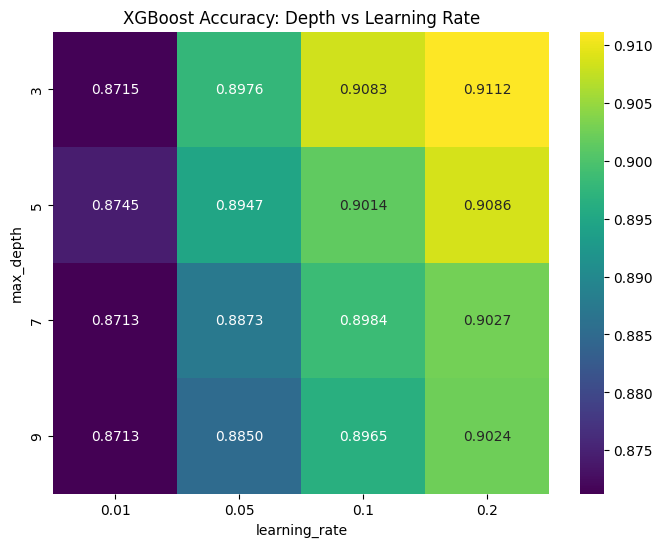

Time-Only Accuracy: 0.9004
Freq-Only Accuracy: 0.8855
Combined Accuracy: 0.9171


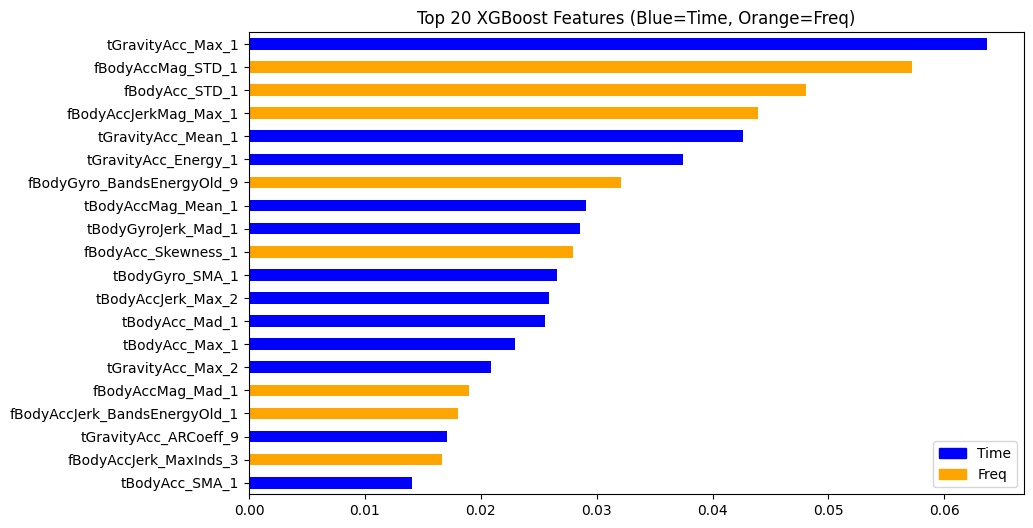

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler

train_df = pd.read_csv('../../data/activity_train.csv')
test_df = pd.read_csv('../../data/activity_test.csv')

X_train = train_df.drop(columns=['activity', 'subject'], errors='ignore')
y_train = LabelEncoder().fit_transform(train_df['activity'])
X_test = test_df.drop(columns=['activity', 'subject'], errors='ignore')
y_test = LabelEncoder().fit_transform(test_df['activity'])

print("Running XGBoost Learning Rate Analysis...")
# Low LR needs more trees, High LR overfits.
lr_range = [0.01, 0.05, 0.1, 0.3, 0.5]
train_scores, test_scores = validation_curve(
    XGBClassifier(n_estimators=100, tree_method='hist', random_state=42), 
    X_train, y_train, 
    param_name="learning_rate", param_range=lr_range,
    cv=3, scoring="accuracy", n_jobs=-1
)

plt.figure(figsize=(8, 5))
plt.plot(lr_range, np.mean(test_scores, axis=1), marker='o', label='CV Score', color='red')
plt.title("XGBoost: Finding the Sweet Spot for Learning Rate")
plt.xlabel("learning_rate")
plt.ylabel("Accuracy")
plt.xscale('log') # Log scale helps view small learning rates
plt.grid(True)
plt.show()

print("Running Grid Search for Heatmap...")
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

grid = GridSearchCV(
    XGBClassifier(n_estimators=100, tree_method='hist', random_state=42),
    param_grid, cv=3, n_jobs=-1
)
grid.fit(X_train_scaled, y_train)

results_df = pd.DataFrame(grid.cv_results_['params'])
results_df['score'] = grid.cv_results_['mean_test_score']
heatmap_data = results_df.pivot(index='max_depth', columns='learning_rate', values='score')

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="viridis")
plt.title("XGBoost Accuracy: Depth vs Learning Rate")
plt.show()

t_cols = [c for c in X_train.columns if c.startswith('t')]
f_cols = [c for c in X_train.columns if c.startswith('f')]

datasets = {"Time-Only": t_cols, "Freq-Only": f_cols, "Combined": X_train.columns}
xgb_best = XGBClassifier(n_estimators=100, learning_rate=0.1, tree_method='hist', random_state=42)

for name, cols in datasets.items():
    xgb_best.fit(X_train[cols], y_train)
    acc = xgb_best.score(X_test[cols], y_test)
    print(f"{name} Accuracy: {acc:.4f}")

xgb_best = grid.best_estimator_
imps = pd.Series(xgb_best.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)

# Color code bars
colors = ['blue' if c.startswith('t') else 'orange' for c in imps.index]

plt.figure(figsize=(10, 6))
imps.plot(kind='barh', color=colors)
plt.gca().invert_yaxis() # Top feature on top
plt.title("Top 20 XGBoost Features (Blue=Time, Orange=Freq)")
from matplotlib.patches import Patch
plt.legend(handles=[Patch(color='blue', label='Time'), Patch(color='orange', label='Freq')])
plt.show()